<a href="https://colab.research.google.com/github/Divyanshu-Singh-Chauhan/MEG_BCI-CLassification/blob/main/Feature_MEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, normalize
from keras.utils import np_utils

import sklearn
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
!pip install mne

from scipy import stats
from scipy.io import loadmat
from scipy.signal import butter, lfilter



import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization, SpatialDropout2D
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.constraints import max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

### LOAD THE DATA

In [ ]:
!wget -O train.mat https://www.dropbox.com/s/9u8xmdh4r9uavn6/ParsedMEGData_P11_S2.mat?dl=0
train_annots = loadmat('train.mat')

!wget -O test.mat https://www.dropbox.com/s/9u8xmdh4r9uavn6/ParsedMEGData_P11_S2.mat?dl=0
test_annots = loadmat('test.mat')

### SOME CONTANTS RELATED TO THE DATASET

In [ ]:
new = True
subject = '11'
img_path = '/content/drive/MyDrive/U_Essex/Final_Model_Weights/MEG/Curves/P'+ subject
path = '/content/drive/MyDrive/U_Essex/Final_Model_Weights/MEG_C_Correlation/P'+subject+'_M'


fs = 500                  # sampling frequency = 500 Hz
t0 = 2.0                  # Starting Seconds to ignore in the data
t_stamp = int(fs*t0)      # 1000 = fs*t0
label_dict = {1:'Hand',
              2:'Feet',
              3:'Word',
              4:'Math'}

### List of all the cortexes by their serial number
MCids= ['064','062','103','041','042','063','104','111','112','044','043','071','072','114','113','181','182','074','073','221','222','183','224']
LTids=['031','011','012','034','032','033','013','021','022','014','151','024','023','154','152','161','162','153','172','164','163']
RTids=['121','124','123','122','141','131','132','144','142','134','133','261','143','262','241','242','264','263','244','243','252']
Fids=['052','081','091','051','053','082','094','092','054','061','101','102','093']
Occids=['184','201','202','223','191','204','203','231','194','192','211','234','232','173','193','212','233','251','174','214','213','254']      

In [ ]:
def data_understand(annots: dict) -> list:

    """Function for understanding the dataset-->.mat file
    
    :*param* dicts: The dictionary conatining the dataset
    :*returns* processed data and target arrays
    """

    print("1. The keys of the dataset are: ", annots.keys())

    data = np.asarray(annots['MEGdata'][0][0][1])             ### annots['MEGdata'][0][0][1] =  samples per trial * channels * trials
    (s_t, ch, trials) = data.shape
    data = data.reshape(trials, ch, s_t)
    print("2. trials, channels, samples per trial a.k.a data shape is: ", trials, ch, s_t)

    labels = np.asarray(annots['MEGdata'][0][0][2])            ### labels per trial
    print("3. labels shape is: ", labels[0].shape)
        
    cds = annots['MEGdata'][0][0][3]               ### Channel Codes
    codes = []
    for i in range(cds.shape[0]):
      codes.append(cds[i][0][0])
    codes = np.asarray(codes)                      ### array of strings of the channel codes .. eg --> 'MEG0123'
    print("4. Codes shape is: ", codes.shape)

    serial_n = np.asarray(annots['MEGdata'][0][0][4])          ### Channels Serial Number
    print("5. Serial_n shape is: ", serial_n.shape)

    classes_names = np.asarray(annots['MEGdata'][0][0][5])     ### Annotations of classes
    print("6. names of the classes are:", classes_names)  

    return data, labels, codes, serial_n, classes_names


"------------------------------------------------------------------------------"


# # Script for considering experiment from 2.5 seconds to 5.5 seconds of data 
def remove_time(X: list)->list:
  """Function for removing the first t0 seconds from the data

  :*param* X: input data array
  :*returns* data with removed elements 
  """
  return X[:,:,int(fs*2.5):int(fs*5.5)]


"------------------------------------------------------------------------------"


### CHANGE THE LABELS ONLY TO TRAIN A DIFFERENT PAIR
def get_data(labels: list, X: list, class_list: list):

    """Function to get the data for the given two classes

    :label 1 -> Hand
    :Label 2 -> Feet
    :Label 3 -> Word
    :Label 4 -> Math

    :*param* labels: Target labels 
    :*param* X: Contains the input data
    :*param* class_list: contains 2 elements for each class required
    :*returns* binary class data from the dataset
    """
    l1 = class_list[0]
    l2 = class_list[1]

    print("The data being considered is for",label_dict[l1],"vs",label_dict[l2])
    ind1_arr = np.where(labels[0]==l1)
    X1 = []
    for i in ind1_arr[0]:
      X1.append(X[i])
    X1 = np.asarray(X1)
    Y1 = np.zeros(50)

    ind2_arr = np.where(labels[0]==l2)
    X2 = []
    for i in ind2_arr[0]:
      X2.append(X[i])
    X2 = np.asarray(X2)
    Y2 = np.ones(50)

    X = np.concatenate((X1,X2), axis = 0)
    Y = np.concatenate((Y1,Y2), axis = 0)

    return X, Y

"------------------------------------------------------------------------------"


def get_encodings(Y: list)->list:

    """Function for transforming target data to one hot encodings

    :*param* Y: Arrays containing target binary labels
    :*returns* transformed one hot encoded array 
    """

    ### CONVERT LABEL OUTPUT TO A ONE HOT ENCODING i.e the shape would be (200,2)
    encoder = LabelEncoder()
    encoder.fit(Y)
    Y = encoder.transform(Y)
    # convert integers to dummy variables (i.e. one hot encoded)
    Y = np_utils.to_categorical(Y)
    return Y


"------------------------------------------------------------------------------"


def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


"------------------------------------------------------------------------------"    

def get_band(band: str)->float:

    """Function to get the frequency band

    :*param* band: string denoting the band
    :*returns* the lower and upper bound of frequency
    """
    if band=='alpha':
      lowcut = 8
      highcut = 12
    elif band == 'beta':
      lowcut = 14
      highcut = 30
    elif band == 'mu':
      lowcut = 12
      highcut = 16
    elif band == 'ab':
      lowcut = 8
      highcut = 30
    else:
      lowcut = 0.5
      highcut = 4
    
    return lowcut,highcut


"------------------------------------------------------------------------------"  


def temporal_filtering(data: list, order: int, band = 'ab')->list:

    """Function to perform temporal filtering

    :*param* data: input array to be filtered
    :*param* order: generally kept as 4 for current task
    :*param* band: denoting the band of frequency required
    :*returns* the temporally filtered signal
    """
    lowcut, highcut = get_band(band)
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = lfilter(b, a, data)
    return filtered


"------------------------------------------------------------------------------"  

# Script for sorting channels into their cortexes and taking only gradiometers
def get_channels(names: list, grad = True)->dict:

    """Function to get the lists of indexes for channels in each cortex


    :*param* name: array of strings containing codes 
    :*param* grad: bool True signifies that we are taking only gradiometers 
    :*returns* dictionary containing the lists for each cortex
    """
    dicts = {}
    dicts['Motor'] = []
    dicts['Left'] = []
    dicts['Right'] = []
    dicts['Frontal'] = []
    dicts['Occids'] = []
    ls = []
    for i in range(len(names)):
      name = names[i]
      n_code = name[3:7]      # numeric code of the channel
      ids = name[3:6]
      if grad == True:
        if n_code[-1] != '1':
          if ids in MCids:
            dicts['Motor'].append(i)
          elif ids in LTids:
            dicts['Left'].append(i)
          elif ids in RTids:
            dicts['Right'].append(i)
          elif ids in Fids:
            dicts['Frontal'].append(i)
          else:
            dicts['Occids'].append(i)
      
      else:
        if ids in MCids:
          dicts['Motor'].append(i)
        elif ids in LTids:
          dicts['Left'].append(i)
        elif ids in RTids:
          dicts['Right'].append(i)
        elif ids in Fids:
          dicts['Frontal'].append(i)
        else:
          dicts['Occids'].append(i)
        
    return dicts


"------------------------------------------------------------------------------"  


def remove_channel(X: list, dicts: dict)->list:

  """Function to get the remove the unnecessary channels from the data

  :*param* X: input filtered array
  :*param* dicts: dictionary containing the channel indexes
  :*returns* input array with removed channels
  """

  M_ids = dicts['Motor']
  L_ids = dicts['Left']
  R_ids = dicts['Right']
  F_ids = dicts['Frontal']
  O_ids = dicts['Occids']

  l1 = []
  for i in range(X.shape[0]):
    l2 = []
    for j in (M_ids+L_ids+R_ids+F_ids+O_ids):                               
      l3 = []
      for k in range(X.shape[2]):
        val = X[i][j][k]
        l3.append(val)
      l2.append(l3)
    l1.append(l2)
  return np.asarray(l1)


"------------------------------------------------------------------------------"  

def min_max_normalized(X: list)->list:

  """Function to get normalized data and an increased dimension at the last axis

  :*param* X: input data array to be normalized
  :*returns normalized input array
  """
  for i in range(X.shape[0]):
    X[i] = normalize(X[i])
  X = np.expand_dims(X, axis=-1)
  return X

"------------------------------------------------------------------------------"  

def z_score_normalized(X:list)->list:
  """Function to get z-score normalized data at the last axis

  :*param* X: input data array to be z-score normalized
  :*returns* z-score normalized array 
  """
  for i in range(X.shape[0]):
    X[i] = stats.zscore(X[i], axis=1)
  X = np.expand_dims(X,axis=-1)
  return X

"------------------------------------------------------------------------------"  

def visualize(X_hand:list, X_feet:list):
  x = np.linspace(0,X_hand.shape[0],X_hand.shape[0])
  print(x.shape)
  fig, (ax1, ax2) = plt.subplots(2)
  fig.suptitle('Horizontally stacked subplots')
  ax1.plot(x, X_hand)
  ax1.set_title("Hand")
  ax2.plot(x, X_feet)
  ax2.set_title("Feet")


"------------------------------------------------------------------------------"  


def prep_data(annots, train = True):

  data, labels, codes, serial_n, classes_names = data_understand(annots)
  X_reduced = remove_time(data)

  X_binary,Y_binary = get_data(labels, X_reduced, [1,2])

  Y = get_encodings(Y_binary)

  X_ab = temporal_filtering(X_binary, 4, band = 'ab')
  X_filtered = X_ab

  this_dict = get_channels(codes, grad = True)
  X_removed = remove_channel(X_filtered, this_dict)

  X = z_score_normalized(X_removed)

  if train == True:
    mode = 'Training'

  else:
    mode = 'Testing'

  np.save('/content/drive/MyDrive/U_Essex/Final_Model_Weights/MEG/Data Arrays/'+mode+'/X_P'+subject, X)
  np.save('/content/drive/MyDrive/U_Essex/Final_Model_Weights/MEG/Data Arrays/'+mode+'/Y_P'+subject, Y)

  return X, Y


"------------------------------------------------------------------------------"  


def eval(X: list, Y: list):
    """Function to evaluate on test data

    *param* X: Input data list 
    *param* Y: Target labels 

    *prints* the test accuracy and test loss scores
    """

    score = model.evaluate(X, Y, verbose = 1) 

    print('loss:', score[0]) 
    print('Accuracy:', score[1])

    from sklearn.metrics import accuracy_score

    probs = model.predict(X)
    print(accuracy_score(Y.argmax(axis=1), probs.argmax(axis=1)))


"------------------------------------------------------------------------------"


def plot_learning(results):

    plt.figure(figsize=(8, 8))
    plt.title("Learning curve")
    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    # plt.savefig(img_path+'_LR')
    plt.legend()


"------------------------------------------------------------------------------"


def plot_roc_curve(Y_predicted: list, Y_actual: list):
    """Function to plot the ROC curve and give AUC value

    :*param* Y_predict: predicted model output in float values
    :*param* Y_actual: actual labels
    :*returns* the ROC plot and AUC values
    """
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_train.argmax(axis=1), probs.argmax(axis=1))

    # calculate AUC
    auc = roc_auc_score(Y_train.argmax(axis=1), probs.argmax(axis=1))
    print('AUC: %.3f' % auc)

    plt.plot(fpr, tpr, marker='.', label='EEGNet')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig(img_path+'_ROC')
    plt.show()


"------------------------------------------------------------------------------"


def bandpower(data, sf, band, method='welch', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp


"------------------------------------------------------------------------------"


def convert_bp(X: list)-> list:
    """Function to calculate the bandpower array corresponding to each waveform

    *param* X: Input data array --> (trials, channels, samples_per_trial)

    *returns* 2D bandpower array of size (trials, channels) with abs. bandpower as each element for every component
    """
    data = []
    trials, channels, s_t = X.shape
    for i in range(trials):
      tr = []
      for j in range(channels):
        bp = bandpower(X[i][j], sf = 500, band=[8, 30])
        tr.append(bp)
      data.append(tr)
    bp_array = np.asarray(data)
    return bp_array


"------------------------------------------------------------------------------"


def return_scores(bp_arr: list, Y: list, k=10)->list:
    """Function to calculate the fit the correlation function
       and calculate the scores for each waveform

    *param* bp_arr: input bandpower array  
    *param* k: k denotes the most imp 'k' features, k=10 default. 

    *returns* a fit array with scores 
    """
    bestfeatures = SelectKBest(score_func=chi2, k=k)
    fit = bestfeatures.fit(bp_arr,Y)
    return fit.scores_


def sort_ids(score: list)->list:
  """Function to generate the sorted indexes with decreasing importance

  *param* score: scores array to be arg sorted to get the important channels

  *returns* argsorted array 
  """
  return np.argsort(score)


"------------------------------------------------------------------------------"


def select_chs(data: list, srt_chs: list, C: int)->list:
  """Function to use only the important channels in the input array

  *param* data: input signal data array
  *param* srt_chs: sorted array with indexes of channels in decreasing importance 
  *param* C: # channels to be selected

  *returns* transformed input data array with important channels 
  """
  ls = []
  for i in range(C):
    ls.append(data[:, srt_chs[i], :])
  return np.asarray(ls)


"------------------------------------------------------------------------------"


def bp_wrapper(data: list, Y:list, C: int)->list:
  """Wrapper function to incorporate the pipeline

  *param* data: input data array (4D array)
  *param* C: # channels to be selected

  *returns* transformed input data array
  """

  data = np.squeeze(data, axis=-1)
  trials, channels, s_t = data.shape
  bp_array = convert_bp(data)
  scores = return_scores(bp_array, Y)
  srt_ch = sort_ids(scores)
  transform = select_chs(data, srt_ch, C)

  transformed = np.expand_dims(transform.reshape(trials, C, s_t), axis=-1)
  return transformed 


In [ ]:
if new == True:
    X_tr, Y_tr = prep_data(train_annots, train = True)
    X_te, Y_te = prep_data(test_annots, train = False)

    print("Train shape is:", X_tr.shape)
    print("Test shape is:", X_te.shape)

else:
    X_tr =  np.load('/content/drive/MyDrive/U_Essex/Final_Model_Weights/MEG/Data Arrays/Training/X_P'+subject+'.npy')
    Y_tr =  np.load('/content/drive/MyDrive/U_Essex/Final_Model_Weights/MEG/Data Arrays/Training/Y_P'+subject+'.npy')

    X_te =  np.load('/content/drive/MyDrive/U_Essex/Final_Model_Weights/MEG/Data Arrays/Testing/X_P'+subject+'.npy')
    Y_te =  np.load('/content/drive/MyDrive/U_Essex/Final_Model_Weights/MEG/Data Arrays/Testing/Y_P'+subject+'.npy')

In [ ]:
X_train = bp_wrapper(data=X_tr, Y=Y_tr, C=100)
Y_train = Y_tr

X_test = bp_wrapper(data=X_te, Y=Y_te, C=100)
Y_test = Y_te

print(X_train.shape)
print(Y_train.shape)


print(X_test.shape)
print(Y_test.shape)

(100, 100, 1500, 1)
(100, 2)
(100, 100, 1500, 1)
(100, 2)


In [ ]:
#### CALLBACKS ####


### MODELCHECKPOINT CALLBACK
save = ModelCheckpoint(path+ '.h5', verbose=1, save_best_only=True, save_weights_only=True)

### REDUCES LR WHEN METRTIC IS NOT IMPROVING
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta =1e-4, min_lr=0.00001, mode='min')

### LEARNING RATE SCHEDULER
def scheduler(epoch):

  if epoch < 5:
     return 0.001
  else:
     return float(0.001 * tf.math.exp(0.1 * (5 - epoch)))
lr_schedule = LearningRateScheduler(scheduler) 

### EARLY STOPPING
early_stopping = EarlyStopping(patience=10, verbose=1)


"---------------------------------------------------------------------------------"


def EEGNet(nb_classes, chans=64, samples = 128, dropoutRate = 0.5,
           kernLength = 32, F1 = 8, D = 2, F2 = 16, norm_rate = 0.25,
           dropoutType = 'Dropout'):
  """
  Keras implementation of EEGNet 
  Parameters:

  nb_classes     : int, number of classes to classify
  chans, samples : number of channels and time stamps in the EEG signal
  dropoutRate    : dropout fraction
  kernLength     : length of temporal convolutions in 1st layer.
  F1, F2         : # of temporal and pointwise filters to learn. Default: F1 = 8, F2 = F1*D
  D              : # of spatial filters to learn withing each temporal convolution. Default: D = 2
  droputType     : Either SpatialDropout2D or Dropout passed as string
  """

  if dropoutType == 'SpatialDropout2D':
    dropoutType = SpatialDropout2D
  elif dropoutType == 'Dropout':
    dropoutType = Dropout
  else:
    raise ValueError('dropout can either be SpatialDropout2D or Dropout, passed as a string.')

  input1 = Input(shape=(chans, samples, 1))

  # Model Architecture
  block1 = Conv2D(F1, (1, kernLength), padding = 'same',
                  input_shape = (chans, samples, 1), 
                  use_bias = False)(input1)
  block1 = BatchNormalization()(block1)
  block1 = DepthwiseConv2D((chans, 1), use_bias = False, 
                           depth_multiplier = D,
                           depthwise_constraint = max_norm(1.))(block1)
  block1 = BatchNormalization()(block1)
  block1 = Activation('elu')(block1)
  block1 = AveragePooling2D((1,4))(block1)
  block1 = dropoutType(dropoutRate)(block1)


  block2 = SeparableConv2D(F2, (1,16), 
                           use_bias = False,
                           padding = 'same')(block1)
  block2 = BatchNormalization()(block2)
  block2 = Activation('elu')(block2)
  block2 = AveragePooling2D((1,8))(block2)
  block2 = dropoutType(dropoutRate)(block2)

  flatten = Flatten(name = 'flatten')(block2)
  dense = Dense(nb_classes, name = 'Dense', 
                kernel_constraint = max_norm(norm_rate))(flatten)
  softmax = Activation('softmax', name = 'softmax')(dense)

  model = Model(inputs=input1, outputs = softmax)
  return model



"------------------------------------------------------------------------------"



model = EEGNet(nb_classes = 2, chans = X_train.shape[1], samples = X_train.shape[2],
                             dropoutRate = 0.5, kernLength = 32, F1 = 8,D = 2, F2 = 16,
                             norm_rate = 0.25, dropoutType = 'Dropout')
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 1500, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 1500, 8)      256       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 1500, 8)      32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 1500, 16)       1600      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1500, 16)       64        
_________________________________________________________________
activation (Activation)      (None, 1, 1500, 16)       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 375, 16)        0     

In [ ]:
from sklearn.utils import shuffle
X_train1, Y_train1 = shuffle(X_train, Y_train)
print(X_train1.shape)
print(Y_train1.shape)


trainX = X_train1[0:75,:,:]
trainY = Y_train1[0:75]
testX = X_train1[75:,:,:]
testY = Y_train1[75:]
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(100, 100, 1500, 1)
(100, 2)
(75, 100, 1500, 1)
(75, 2)
(25, 100, 1500, 1)
(25, 2)


In [ ]:
# model.load_weights(path+ '.h5')
class_weights = {0:1, 1:1}
results = model.fit(trainX, trainY,batch_size=16, epochs=200, validation_data = (testX, testY), callbacks=[save, lr_schedule], class_weight = class_weights)

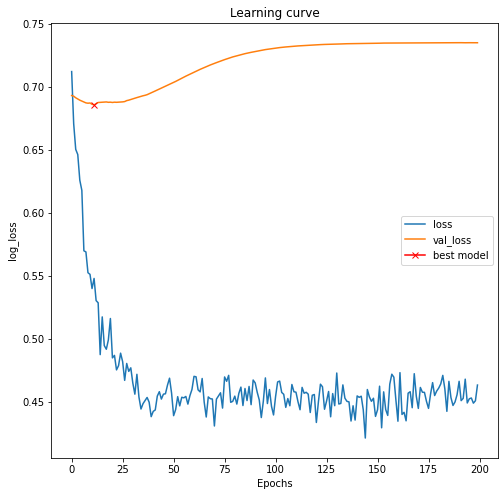

In [ ]:
plot_learning(results)

# EVALUATION

In [ ]:
print("TEST METRICS")
eval(X_test, Y_test)

TEST METRICS
4/4 [==============================] - 0s 24ms/step - loss: 0.7310 - accuracy: 0.4700
loss: 0.7310126423835754
Accuracy: 0.4699999988079071
0.47


In [ ]:
print("TRAIN METRICS")
eval(X_train, Y_train)

TRAIN METRICS
4/4 [==============================] - 0s 12ms/step - loss: 0.5145 - accuracy: 0.8000
loss: 0.5144726037979126
Accuracy: 0.800000011920929
0.8


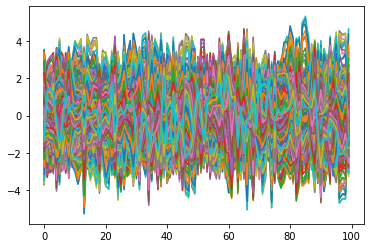

In [ ]:
plt.plot(np.squeeze(X_train[0], axis=-1))
plt.show()

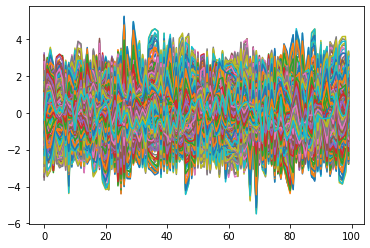

In [ ]:
plt.plot(np.squeeze(X_train[99], axis=-1))
plt.show()

In [ ]:
print("TRAIN METRICS")
eval(X_train, Y_train)

TRAIN METRICS
4/4 [==============================] - 0s 14ms/step - loss: 0.5145 - accuracy: 0.8000
loss: 0.5144726037979126
Accuracy: 0.800000011920929
0.8


In [ ]:
print("TRAIN METRICS")
eval(X_test, Y_test)

TRAIN METRICS
4/4 [==============================] - 0s 13ms/step - loss: 0.7310 - accuracy: 0.4700
loss: 0.7310126423835754
Accuracy: 0.4699999988079071
0.47


In [ ]:
def wrapper(annots, k=32):

    cds = annots['MEGdata'][0][0][3]               ### Channel Codes
    codes = []
    for i in range(cds.shape[0]):
      codes.append(cds[i][0][0])
    codes = np.asarray(codes)                      ### array of strings of the channel codes .. eg --> 'MEG0123'
    print("Codes shape is: ", codes.shape)


    ch = loadmat('/content/drive/MyDrive/U_Essex/H_F.mat')
    a = ch['select_chan']

    channels = []
    for i in range(a.shape[0]):
      channels.append(chs[i][0][0])

    dicts = {}
    for i in range(codes.shape[0]):
      dicts[codes[i]] = i

    t = 0
    ls = []

    for i in channels:
      if t==k:
        break
      if i in codes:
        ls.append(dicts[i])
        t+=1

    return ls

In [ ]:
ls = wrapper(test_annots, 32)
ls